In [1]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from functools import partial
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/toc3/press


In [2]:
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.components import press
from express.visualization import plot_action
from express.utils import add_names
import express.config as config

In [3]:
model = "xgboost" #"xgboost"
trial = 4

save_path = os.path.join(base_path, "stores", "model", model, f"{trial:03d}", "component.pkl")
path = Path(save_path)
component = pickle.load(path.open(mode="rb"))
component

In [4]:
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")
test_db = SQLiteDatabase(TEST_DB_PATH)
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))

if model == "xgboost":
    xfns = ["startlocation", "closest_11_players"]
    nb_prev_actions = 3
elif model == "soccermap":
    xfns = ["startlocation", "freeze_frame_360"]
    nb_prev_actions = 1

test_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "test"),
    xfns=xfns,
    yfns=["counterpress"],
    load_cached=True,
    nb_prev_actions=nb_prev_actions
)

print(f"Test DataSet: {test_dataset.features.shape}")
print(f"Test Dataset: {test_dataset.labels.value_counts().to_dict()}")

Test DataSet: (12406, 195)
Test Dataset: {(False,): 9954, (True,): 2452}


In [5]:
component.test(dataset_test)

{'precision': 0.7106681034482759,
 'recall': 0.5379282218597063,
 'f1': 0.6123491179201485,
 'log_loss': 0.3166872054471614,
 'brier': 0.09556845523801184,
 'roc_auc': 0.8953104140383448}

In [6]:
from express.simulates import expressXGBoostComponent, exPressPytorchComponent

simulate = expressXGBoostComponent(component, test_dataset)

idx = (3895202, 555)
game_id = idx[0]
simulate.predict(idx=idx)

0.12068987

In [7]:
target = "actor" # player_id: actor, teammate_1, opponent_1, teammate_2, opponent_2,.....teammate_11, opponent_11
results = simulate.adjust_player_positions(idx=idx, target=target)
results

[{'dx': -5,
  'dy': -5,
  'action': start_x_a0                 48.1125
  start_y_a0                 29.5100
  start_x_a1                 56.4375
  start_y_a1                 34.5100
  start_x_a2                 62.4750
                              ...   
  opponent_10_y_a2               NaN
  opponent_10_distance_a2        NaN
  opponent_11_x_a2               NaN
  opponent_11_y_a2               NaN
  opponent_11_distance_a2        NaN
  Name: (3895202, 555), Length: 195, dtype: float64,
  'probability': 0.12068987},
 {'dx': -5,
  'dy': -4,
  'action': start_x_a0                 48.1125
  start_y_a0                 30.5100
  start_x_a1                 56.4375
  start_y_a1                 34.5100
  start_x_a2                 62.4750
                              ...   
  opponent_10_y_a2               NaN
  opponent_10_distance_a2        NaN
  opponent_11_x_a2               NaN
  opponent_11_y_a2               NaN
  opponent_11_distance_a2        NaN
  Name: (3895202, 555), Length: 195

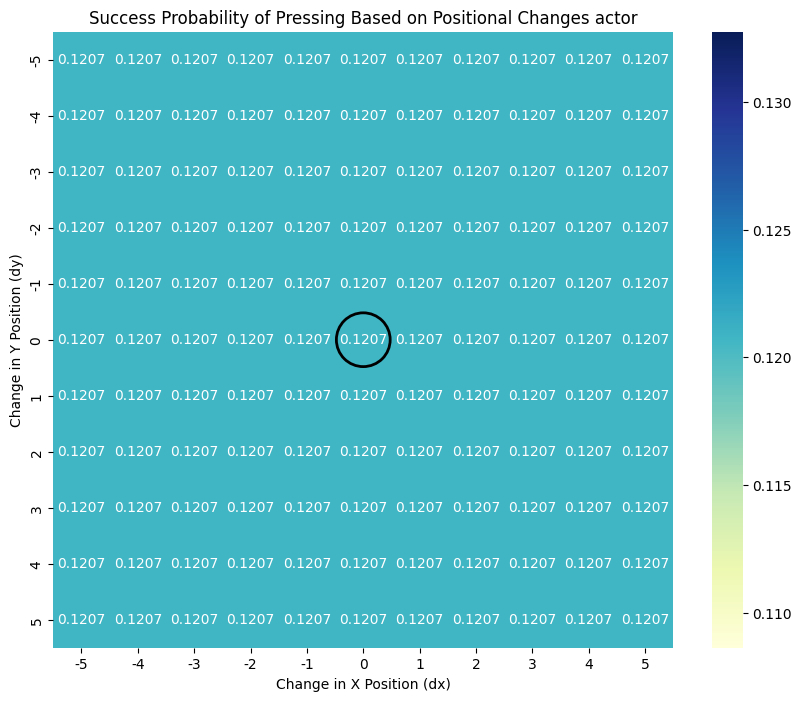

In [9]:
df_results = pd.DataFrame(results)

pivot_table = df_results.pivot(index='dy', columns='dx', values='probability')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".4f")

plt.scatter(x=pivot_table.columns.get_loc(0) + 0.5,  # x축 위치
            y=pivot_table.index.get_loc(0) + 0.5,    # y축 위치
            s=1500, edgecolor='black', facecolor='none', linewidth=2)

plt.title(f'Success Probability of Pressing Based on Positional Changes {target}')
plt.xlabel('Change in X Position (dx)')
plt.ylabel('Change in Y Position (dy)')
plt.show()

In [11]:
df_actions = add_names(test_db.actions(3895202))
home_team_id, away_team_id = test_db.get_home_away_team_id(game_id=game_id)
df_actions.head(2)

original_event_id  period_id  \
game_id action_id                                                    
3895202 0          b98b3109-8cb2-4017-8960-a8cb2a1937c1          1   
        1          c2231776-f3ce-43d6-b431-0af2dc65c313          1   

                   time_seconds  team_id  player_id  start_x  start_y  \
game_id action_id                                                       
3895202 0                 0.575      182      39167  52.0625   34.425   
        1                 1.016      182      16532  49.2625   31.875   

                     end_x   end_y  bodypart_id  ...  play_pattern_name  \
game_id action_id                                ...                      
3895202 0          49.2625  31.875            4  ...      From Kick Off   
        1          48.5625  31.875            0  ...      From Kick Off   

                   under_pressure  duration  \
game_id action_id                             
3895202 0                       0  0.440712   
        1                       0  0.120000   

                                                               extra  \
game_id action_id                                                      
3895202 0          {'pass': {'recipient': {'id': 16532, 'name': '...   
        1                  {'carry': {'end_location': [56.0, 43.0]}}   

                   visible_area_360  in_visible_area_360 freeze_frame_360  \
game_id action_id                                                           
3895202 0                      None                    0             None   
        1                      None                    0             None   

                  type_name  result_name bodypart_name  
game_id action_id                                       
3895202 0              pass      success     foot_left  
        1           dribble      success          foot  

[2 rows x 23 columns]

KeyError: 'team_id'

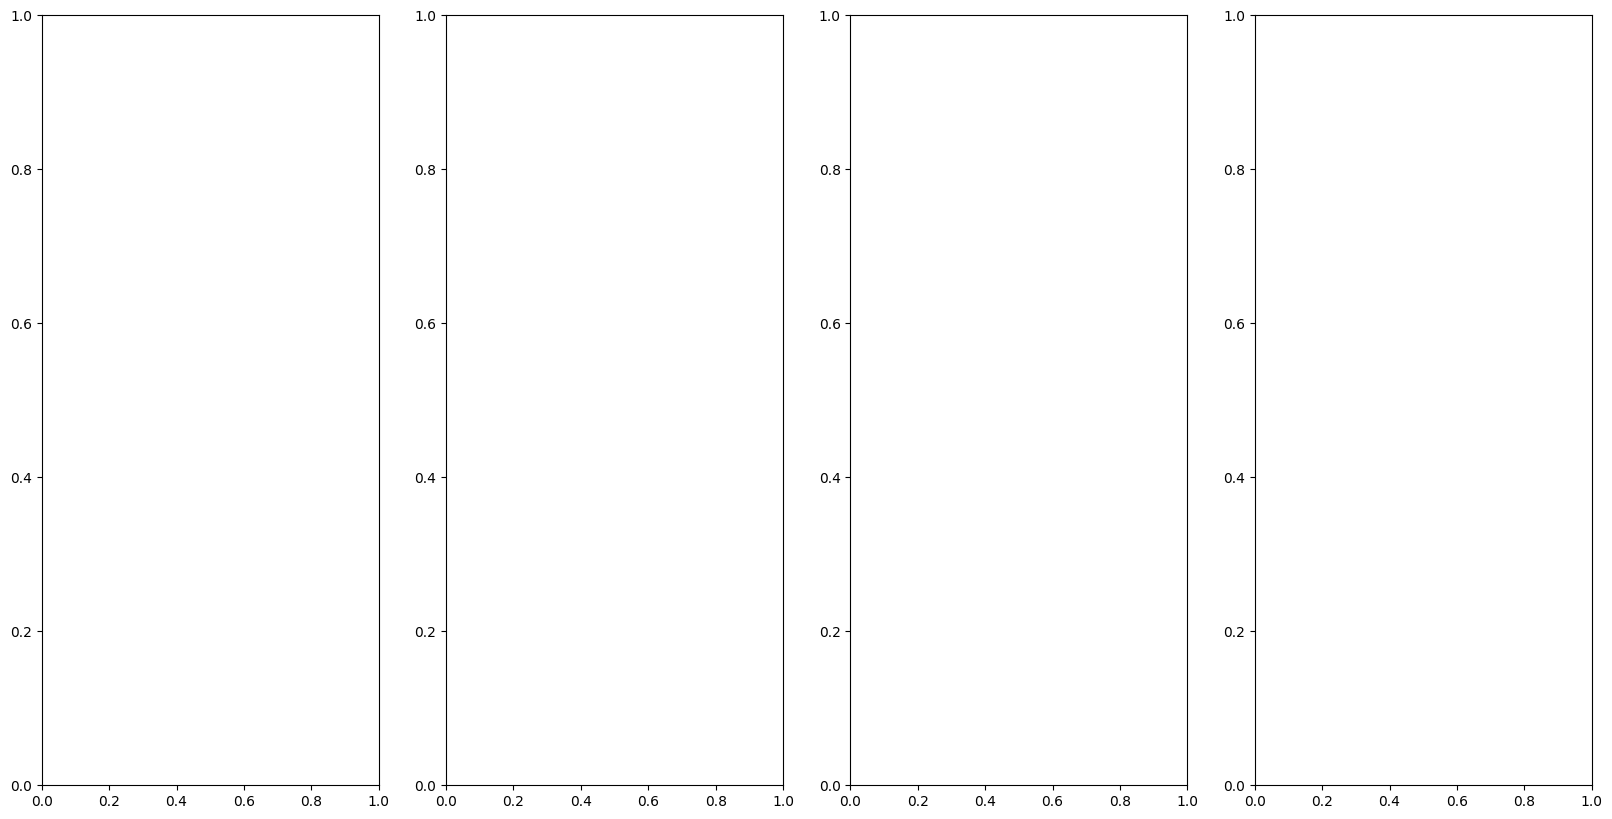

In [ ]:
k = 3

raw_data = df_results[(df_results['dx'] == 0) & (df_results['dy'] == 0)]
df_top_k = df_results[~((df_results['dx'] == 0) & (df_results['dy'] == 0))].nlargest(k, 'probability')
combined_data = pd.concat([raw_data, df_top_k]).reset_index(drop=True)

fig, axes = plt.subplots(1, len(combined_data), figsize=(20, 10))
for i, (_, row) in enumerate(combined_data.iterrows()):
    plot_action(
        action= row["action"],
        home_team_id=home_team_id,
        prob=row["probability"],
        ax=axes[i]
    )

    title_prefix = "Raw Data" if (row["dx"] == 0 and row["dy"] == 0) else f"Top {i}"
    axes[i].set_title(f"{title_prefix} (prob: {row['probability']:.2f})")

# 레이아웃 조정
plt.tight_layout()
plt.show()


In [ ]:
df_results[df_results["dx"] == 0]

,dx,dy,probability
55,0,-5,0.10022
56,0,-4,0.10022
57,0,-3,0.10022
58,0,-2,0.10022
59,0,-1,0.10022
60,0,0,0.10022
61,0,1,0.10022
62,0,2,0.10022
63,0,3,0.10022
64,0,4,0.10022


<Axes: title={'center': 'pressing & fail: 0.1207'}>

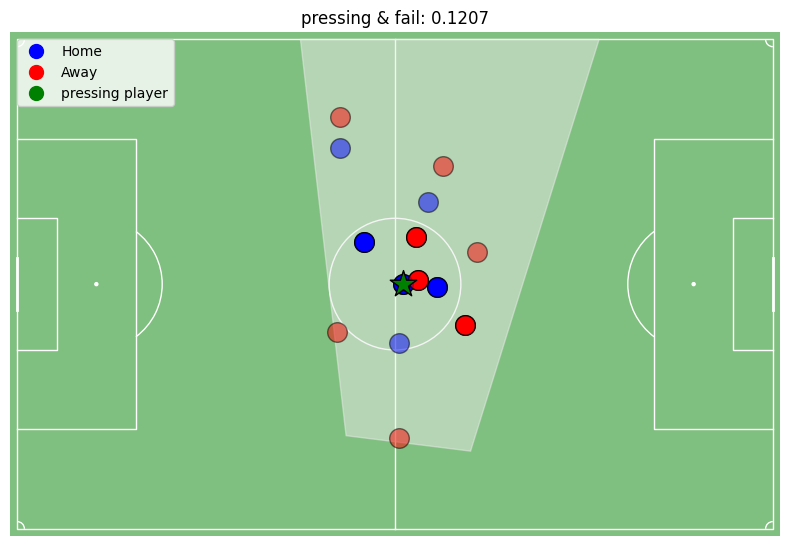

In [ ]:
home_team_id, away_team_id = test_db.get_home_away_team_id(game_id = game_id)

in_visible_area_360 = df_actions.loc[idx]["in_visible_area_360"]
actiontype_id = df_actions.loc[idx, "type_id"]
prob = simulate.predict(idx)

plot_action(df_actions.loc[idx], show_visible_area=in_visible_area_360, home_team_id=home_team_id, prob=prob)

In [ ]:
label_column = "counterpress"
y_pred = component.predict(dataset_test)
y_true = test_dataset.labels[label_column]

In [ ]:
test_dataset.features

start_x_a0  start_y_a0  \
game_id action_id                           
3857255 6             85.6625      55.760   
        17            50.9250      57.375   
        22            56.4375      10.880   
        25            65.0125      43.010   
        40            39.6375      24.990   
...                       ...         ...   
3895348 2818          51.3625      38.590   
        2834          34.4750      38.080   
        2847           4.9875      58.395   
        2848           6.6500      60.520   
        2853          97.2125      50.320   

                                                 freeze_frame_360_a0  
game_id action_id                                                     
3857255 6          [{'actor': False, 'keeper': False, 'teammate':...  
        17         [{'actor': False, 'keeper': False, 'teammate':...  
        22         [{'actor': False, 'keeper': False, 'teammate':...  
        25         [{'actor': False, 'keeper': False, 'teammate':...  
        40         [{'actor': False, 'keeper': False, 'teammate':...  
...                                                              ...  
3895348 2818       [{'actor': False, 'keeper': False, 'teammate':...  
        2834       [{'actor': False, 'keeper': False, 'teammate':...  
        2847       [{'actor': False, 'keeper': True, 'teammate': ...  
        2848       [{'actor': False, 'keeper': True, 'teammate': ...  
        2853       [{'actor': False, 'keeper': False, 'teammate':...  

[12406 rows x 3 columns]

In [ ]:
pd.DataFrame(df_actions.loc[pressure_idx]["freeze_frame_360"])

NameError: name 'df_actions' is not defined

In [ ]:
pd.DataFrame(test_dataset.features.iloc[0]["freeze_frame_360_a0"].tolist())

,actor,keeper,teammate,x,y
0,False,False,False,66.402636,46.094568
1,False,False,False,68.175241,68.747046
2,False,False,False,69.839902,18.606096
3,False,False,False,82.675556,34.414054
4,True,False,True,86.100001,55.335000
5,False,False,False,89.465247,56.633457


In [ ]:
test_dataset.features["freeze_frame_360_a0"].iloc[0]

array([{'actor': False, 'keeper': False, 'teammate': False, 'x': 66.40263608328932, 'y': 46.094567866742004},
       {'actor': False, 'keeper': False, 'teammate': False, 'x': 68.17524134820296, 'y': 68.74704611379114},
       {'actor': False, 'keeper': False, 'teammate': False, 'x': 69.83990236633127, 'y': 18.606095649369955},
       {'actor': False, 'keeper': False, 'teammate': False, 'x': 82.67555632026671, 'y': 34.41405393462132},
       {'actor': True, 'keeper': False, 'teammate': True, 'x': 86.10000133514404, 'y': 55.335000324249265},
       {'actor': False, 'keeper': False, 'teammate': False, 'x': 89.46524650507118, 'y': 56.63345693562979}],
      dtype=object)

In [ ]:
test_dataset.features

start_x_a0  start_y_a0  \
game_id action_id                           
3857255 6             85.6625      55.760   
        17            50.9250      57.375   
        22            56.4375      10.880   
        25            65.0125      43.010   
        40            39.6375      24.990   
...                       ...         ...   
3895348 2818          51.3625      38.590   
        2834          34.4750      38.080   
        2847           4.9875      58.395   
        2848           6.6500      60.520   
        2853          97.2125      50.320   

                                                 freeze_frame_360_a0  
game_id action_id                                                     
3857255 6          [{'actor': False, 'keeper': False, 'teammate':...  
        17         [{'actor': False, 'keeper': False, 'teammate':...  
        22         [{'actor': False, 'keeper': False, 'teammate':...  
        25         [{'actor': False, 'keeper': False, 'teammate':...  
        40         [{'actor': False, 'keeper': False, 'teammate':...  
...                                                              ...  
3895348 2818       [{'actor': False, 'keeper': False, 'teammate':...  
        2834       [{'actor': False, 'keeper': False, 'teammate':...  
        2847       [{'actor': False, 'keeper': True, 'teammate': ...  
        2848       [{'actor': False, 'keeper': True, 'teammate': ...  
        2853       [{'actor': False, 'keeper': False, 'teammate':...  

[12406 rows x 3 columns]

In [ ]:
y_pred

functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/press/stores/datasets/test')

### Application

In [ ]:
idx = (3857255, 6)

sample_features = {}
sample_target = {}
sample_features = test_dataset.features.loc[idx].to_dict()
game_id, action_id = test_dataset.features.loc[idx].name

sample_target = test_dataset.labels.loc[idx].to_dict()
game_id, action_id = test_dataset.labels.loc[idx].name

sample = {
    "game_id": game_id,
    "action_id": action_id,
    **sample_features,
    **sample_target,
}
sample

{'game_id': 3857255,
 'action_id': 6,
 'start_x_a0': 85.66250000000001,
 'start_y_a0': 55.76,
 'freeze_frame_360_a0': array([{'actor': False, 'keeper': False, 'teammate': False, 'x': 66.40263608328932, 'y': 46.094567866742004},
        {'actor': False, 'keeper': False, 'teammate': False, 'x': 68.17524134820296, 'y': 68.74704611379114},
        {'actor': False, 'keeper': False, 'teammate': False, 'x': 69.83990236633127, 'y': 18.606095649369955},
        {'actor': False, 'keeper': False, 'teammate': False, 'x': 82.67555632026671, 'y': 34.41405393462132},
        {'actor': True, 'keeper': False, 'teammate': True, 'x': 86.10000133514404, 'y': 55.335000324249265},
        {'actor': False, 'keeper': False, 'teammate': False, 'x': 89.46524650507118, 'y': 56.63345693562979}],
       dtype=object),
 'counterpress': False}

In [ ]:
from express.components.soccermap import ToSoccerMapTensor
transform = ToSoccerMapTensor(dim=(68, 104))

tensor_data = transform(sample)[0][7]

print(tensor_data.shape)
tensor_data

torch.Size([68, 104])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [ ]:
component.model(transform(sample)[0])

tensor([[0.0814]], grad_fn=<SigmoidBackward0>)

In [ ]:
df_pred = pd.DataFrame(y_pred, index=test_dataset.features.index, columns=test_dataset.labels.columns)
df_pred

counterpress
game_id action_id              
3857255 6              0.081361
        17             0.078102
        22             0.134558
        25             0.110227
        40             0.102862
...                         ...
3895348 2818           0.062434
        2834           0.115184
        2847           0.041475
        2848           0.095037
        2853           0.555428

[12406 rows x 1 columns]

In [ ]:
game_ids = list(df_pred.index.get_level_values('game_id').unique())
game_id = 3857255#game_ids[0]

print(game_id)
df_actions = add_names(test_db.actions(game_id)).reset_index()
df_actions.head()

3857255


,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,play_pattern_name,under_pressure,duration,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3857255,0,8b26aef6-09bc-4cc7-87a8-2b547c0b44f7,1,0.540,772,133353,52.0625,33.660,78.9250,...,From Kick Off,0,1.793392,"{'pass': {'recipient': {'id': 6892, 'name': 'P...","[[89.57332889084125, 68.0], [68.77267355099548...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right
1,3857255,1,da8a2bc2-28d0-48f8-8d69-522e47530e2a,1,2.334,772,6892,78.9250,27.200,76.1250,...,From Kick Off,0,1.389570,"{'carry': {'end_location': [33.5, 32.7]}}","[[99.64777529798958, 68.0], [75.35694264065879...",1,"[{'teammate': True, 'actor': True, 'keeper': F...",dribble,success,foot
2,3857255,2,57365d40-4701-486a-8c96-ed35af64f4eb,1,3.723,772,6892,76.1250,27.370,31.4125,...,From Kick Off,0,2.655969,"{'pass': {'recipient': {'id': 68574, 'name': '...","[[99.83713280330954, 68.0], [75.42532118557196...",0,"[{'teammate': True, 'actor': True, 'keeper': F...",pass,fail,foot_left
3,3857255,3,368d9a8b-7c8e-4dc2-9363-8aac056dae54,1,6.379,778,5690,30.6250,61.200,62.0375,...,From Kick Off,1,0.000000,"{'clearance': {'head': True, 'body_part': {'id...","[[28.21450064148319, 6.3044786146363805], [3.2...",0,"[{'teammate': True, 'actor': False, 'keeper': ...",clearance,success,head
4,3857255,4,5aff0d66-50f1-4b05-893d-266b0964519a,1,12.931,772,3957,62.0375,67.575,76.4750,...,From Throw In,0,1.003935,"{'pass': {'recipient': {'id': 6765, 'name': 'R...","[[83.76973182280807, 68.0], [69.07632091801368...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",throw_in,success,other


In [ ]:
pd.DataFrame(df_actions.loc[pressure_idx]["freeze_frame_360"])

,teammate,actor,keeper,x,y
0,False,False,False,66.402636,46.094568
1,False,False,False,68.175241,68.747046
2,False,False,False,69.839902,18.606096
3,False,False,False,82.675556,34.414054
4,True,True,False,86.100001,55.335000
5,False,False,False,89.465247,56.633457


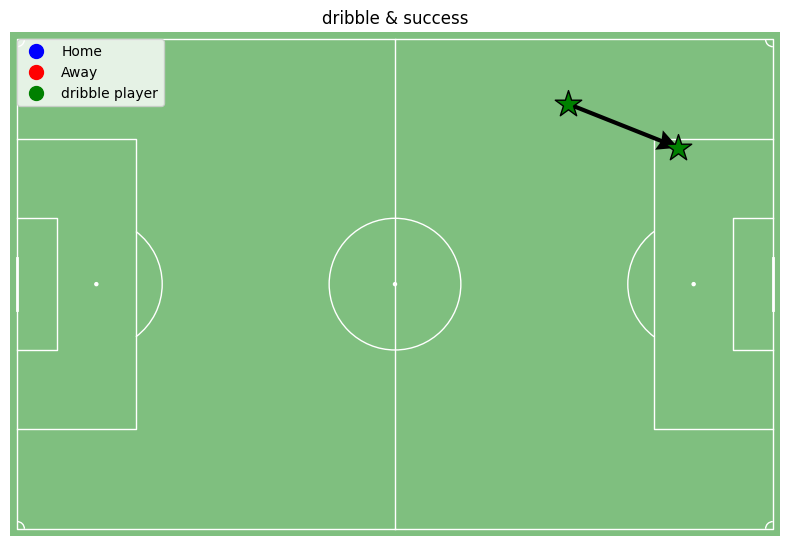

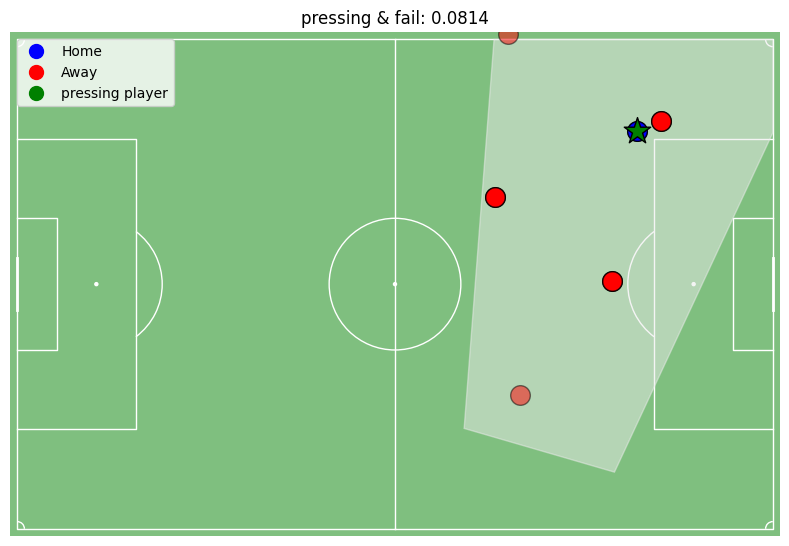

In [ ]:
condition = (df_actions["type_name"] == "pressing")
# condition = (df_actions["type_name"] == "pressing") & (df_actions["result_name"] == "success")
# condition = (df_actions["action_id"] == 1609)
pressure_idx = df_actions[condition].index[0]

home_team_id, away_team_id = test_db.get_home_away_team_id(game_id = game_id)

for idx in range(pressure_idx-1, pressure_idx+1):
    in_visible_area_360 = df_actions.loc[idx]["in_visible_area_360"]
    actiontype_id = df_actions.at[idx, "type_id"]
    index = tuple(df_actions.loc[idx, ["game_id", "action_id"]].values)
    prob = df_pred.loc[index, "counterpress"] if actiontype_id == config.actiontypes.index("pressing") else None

    plot_action(df_actions.loc[idx], show_visible_area=in_visible_area_360, home_team_id=home_team_id, prob=prob)